In [1]:
import torch
from sac_learn_cartpole_with_hyperplanes_actor import Actor
from gymnasium.envs.registration import register
from envs.cartpole_pret_gymnasium import CartPoleEnv
register(
    id="customEnvs/CartPoleEnvParamActions",
    entry_point="envs.cartpole_pret_gymnasium_hyperparamactions:CartPoleEnvParamActions",
)
#RL-DH/envs/cartpole_pret_gymnasium.py

def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
            print(env.metadata.get("render_fps", None))
        else:
            env = gym.make(env_id)
        from gymnasium.wrappers.time_limit import TimeLimit
        env = TimeLimit(env, 500)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env

    return thunk

import gymnasium as gym
import numpy as np
from gymnasium.wrappers.time_limit import TimeLimit
envs = gym.vector.SyncVectorEnv([make_env("customEnvs/CartPoleEnvParamActions", 0, 0, False, "run_name")])
actor = Actor(envs)

# Load the model's state_dict (parameters)
actor.load_state_dict(torch.load('/home/artur/Schreibtisch/DiscriminatingHyperplaneFork/discriminating-hyperplane/videos/customEnvs/actor_model.pth'))


2024-11-15 15:49:14.924206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/artur/miniconda3/envs/fsrl/lib/python3.8/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment customEnvs/CartPoleEnvParamActions already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/artur/miniconda3/envs/fsrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/tmp/ipykernel_65769/1858345613.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pick

<All keys matched successfully>

In [23]:
obs = torch.Tensor([[1,0,0.4,0]])
actions, var, mean = actor.get_action(obs)
actions = actions.detach().cpu().numpy()
print(mean)
print(var)
print(actions)

tensor([[-0.0015, -0.0034]], grad_fn=<AddBackward0>)
tensor([[0.0498, 0.0498]], grad_fn=<ExpBackward0>)
[[-1.         -0.02168578]]


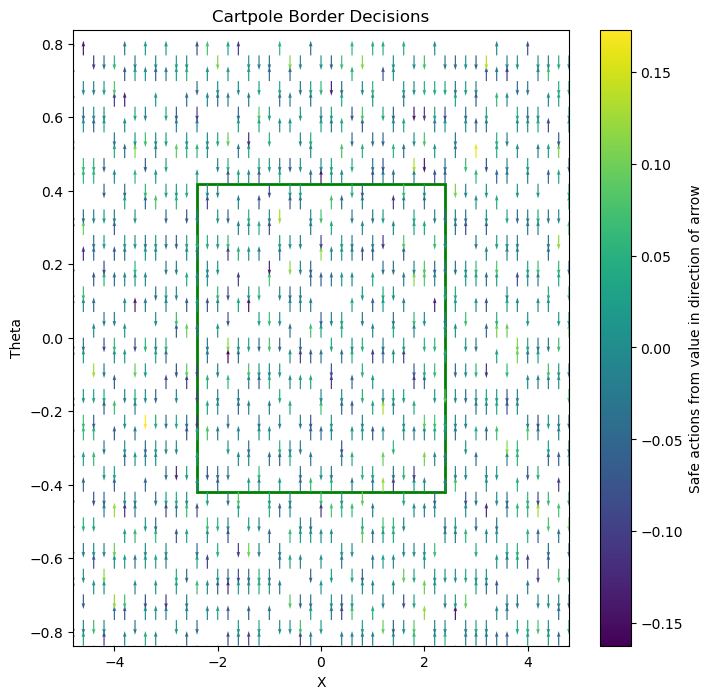

In [24]:
#Plot the hyperplanes in safe direction for all states
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
safe_radians = 24 * 2 * math.pi / 360
borders = []
arrowDirX=[]
arrowDirY=[]
safe_x=2.4
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
colors = []
for x in np.arange(-2.4-2.4,2.5+2.4,0.2):
    for theta in np.arange(-safe_radians*2,safe_radians*2,math.pi / 360 *8):
        o=[x,0,theta,0]
        actions, _, _ = actor.get_action(obs)
        a_h,b_h = actions[0]
        borders.append([x,theta])
        a_h = a_h.detach().numpy()
        b_h = b_h.detach().numpy()
        threshold = np.clip((b_h/a_h),-1,1)
        if(a_h>0):
            to_right_is_dangerous = False
        else:
            to_right_is_dangerous = True
        if to_right_is_dangerous:
            arrowDirX.append(0)
            arrowDirY.append(-1)
            colors.append(threshold)
        else:
            arrowDirX.append(0)
            arrowDirY.append(1)
            colors.append(threshold)
borders = np.array(borders)
rectangle = patches.Rectangle((-safe_x, -safe_radians), 2*safe_x, 2*safe_radians, linewidth=2, edgecolor='green', facecolor='white')
ax.add_patch(rectangle)
quiver_plot=plt.quiver(borders[:,0], borders[:,1], arrowDirX, arrowDirY,colors, cmap ="viridis", angles='xy', scale_units='xy', scale=25)
# This are the borders of the simulation
plt.axis([-2*safe_x, 2*safe_x, -2*safe_radians, 2*safe_radians])
plt.colorbar(quiver_plot, label="Safe actions from value in direction of arrow")            
plt.xlabel("X")
plt.ylabel("Theta")
plt.title("Cartpole Border Decisions")
plt.show()